In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import probdownscale
reload(probdownscale.TaskExtractor)
reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD

from probdownscale.TaskExtractor import TaskExtractor
import math
import numpy as np
import netCDF4 as nc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd
from matplotlib import pyplot as plt

## 1. Debug TaskExtractor

In [8]:
file_path_g_05 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20050516-20060515.nc'
file_path_g_06 =  r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20060516-20070515.nc'
file_path_m = r'C:\Users\96349\Documents\Downscale_data\MERRA2\MERRA2_aerosol_variables_over_MiddleEast_daily_20000516-20180515.nc'
target_var = 'BCSMASS'

# read data
g05_data = nc.Dataset(file_path_g_05)
g06_data = nc.Dataset(file_path_g_06)
m_data_nc = nc.Dataset(file_path_m)

# define lat&lon of MERRA, G5NR and mete
M_lons = m_data_nc.variables['lon'][:15]
# self.M_lons = (M_lons-M_lons.mean())/M_lons.std()
M_lats = m_data_nc.variables['lat'][:15]
# self.M_lats = (M_lats-M_lats.mean())/M_lats.std()
G_lons = g05_data.variables['lon'][:30]
# self.G_lons = (G_lons-G_lons.mean())/G_lons.std()
G_lats = g05_data.variables['lat'][:30]

# extract target data
g_data = np.concatenate((g05_data.variables[target_var][:, :30, :30], g06_data.variables[target_var][:, :30, :30]), axis=0)
m_data = m_data_nc.variables[target_var][5*365:7*365, :15, :15]

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packag

In [9]:
data = [g_data, m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 3
test_proportion = 0.3
n_lag = 10
taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

In [18]:
train_x, train_y, test_x, test_y, location = taskextractor._get_random_task()

In [10]:
locations = taskextractor.get_grid_locations()

In [32]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(10)


In [35]:
train_x, train_y, test_x, test_y, locations = taskextractor.get_random_tasks(locations=locations[:4])

In [14]:
from random import sample
sample([1,2,3,4], 4)

[3, 1, 4, 2]

In [41]:
locations[5:10]

[]

In [40]:
10//3

3

## 2. Test Network

In [145]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow_probability import distributions as tfd

In [312]:
# the last channel is the comonents
alpha = np.random.rand(3,2,5)
alpha = alpha/alpha.sum()
mu = np.random.rand(3, 2, 5)
mu = np.abs(mu)
test_md = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Gamma(concentration=mu, rate=mu))

In [120]:
log_like = test_md.log_prob(np.ones((3,2))*-0.001)
#-tf.reduce_mean(log_like, axis=-1)
log_like

# when the Y is really small, log_prob return a positive log likelihood

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[nan, nan],
       [nan, nan],
       [nan, nan]])>

In [313]:
test_md.mean()

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[0.15880819, 0.10569395],
       [0.17997603, 0.15908541],
       [0.20016422, 0.19627221]])>

In [80]:
log_like

<tf.Tensor: shape=(3, 2), dtype=float64, numpy=
array([[-1.07151844, -1.96976935],
       [-0.88054633, -1.06112697],
       [-1.63395563, -0.41498473]])>

In [160]:
a =  np.random.rand(3,3,3)
#a = (a - a.min())/(a.max() - a.min())
a = a/a.sum()
a.sum()

1.0

In [19]:
# define necessary tool functions
components = 100
no_parameters = 2

def nnelu(input):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def slice_parameter_vectors(parameter_vector, no_parameters):
    return [parameter_vector[:, i * task_dim*task_dim*components:(i + 1) *task_dim*task_dim*components] for i in range(no_parameters)]

def gamma_loss(y, parameter_vector):
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector, 3)  # Unpack parameter vectors
    #print(alpha.shape, mu.shape)
    alpha1 = tf.reshape(alpha, (tf.shape(alpha)[0], task_dim, task_dim, components))
    mu1 = tf.reshape(mu, (tf.shape(mu)[0], task_dim, task_dim, components))
    sigma1 = tf.reshape(sigma,  (tf.shape(sigma)[0], task_dim, task_dim, components))
    #print(alpha1.shape, mu1.shape)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha1),
        components_distribution=tfd.Gamma(
        concentration=mu1, rate=sigma1)
    )

    log_likelihood = gm.log_prob(y)  # Evaluate log-probability of y
    #print(log_likelihood)
    return -tf.reduce_mean(log_likelihood, axis=-1)

def exponential_loss(y, parameter_vector):
    alpha, mu = slice_parameter_vectors(parameter_vector, 2)  # Unpack parameter vectors
    #print(alpha.shape, mu.shape)
    alpha1 = tf.reshape(alpha, (tf.shape(alpha)[0], task_dim, task_dim, components))
    mu1 = tf.reshape(mu, (tf.shape(mu)[0], task_dim, task_dim, components))
    #print(alpha1.shape, mu1.shape)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha1),
        components_distribution=tfd.Exponential(
        rate=mu1)
    )

    log_likelihood = gm.log_prob(y)  # Evaluate log-probability of y
    #print(log_likelihood)
    return -tf.reduce_mean(log_likelihood, axis=-1)

def gamma_mean_loss(y, parameter_vector):
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector, 3)  # Unpack parameter vectors
    #print(alpha.shape, mu.shape)
    alpha1 = tf.reshape(alpha, (tf.shape(alpha)[0], task_dim, task_dim, components))
    mu1 = tf.reshape(mu, (tf.shape(mu)[0], task_dim, task_dim, components))
    sigma1 = tf.reshape(sigma,  (tf.shape(sigma)[0], task_dim, task_dim, components))
    #print(alpha1.shape, mu1.shape)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha1),
        components_distribution=tfd.Gamma(
        concentration=mu1, rate=sigma1)
    )
    mae = tf.keras.losses.MeanAbsoluteError()
    return mae(gm.mean(), y) 


tf.keras.utils.get_custom_objects().update({'nnelu': layers.Activation(nnelu)})

def plot_history(history, title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    
def model_generator(n_para=2):
    # define MDN Exponentialmodel
    # input dim (time, channel, rows, cols)
    input1 = layers.Input(shape=(n_lag, 1, task_dim, task_dim)) 
    input1 = layers.BatchNormalization()(input1)
    input2 = layers.Input(shape=(task_dim, task_dim, 1))
    input2 = layers.BatchNormalization()(input2)
    input3 = layers.Input(shape=(1))
    input3 = layers.BatchNormalization()(input3)

    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='tanh', return_sequences=True)(input1)
    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='relu', return_sequences=True)(X)
    X = layers.ConvLSTM2D(filters=20, kernel_size=(1,1), activation='relu')(X)
    X = layers.Flatten()(X)
    X = layers.Dense(512, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(300, activation='relu')(X)

    X1 = layers.Conv2D(20, (2,2), activation='tanh')(input2)
    X1 = layers.Flatten()(X1)
    X2 = layers.BatchNormalization()(input3)
    X2 = layers.Dense(30, activation='relu')(X2)

    X = layers.Concatenate()([X, X1, X2])
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Dense(128, activation='relu')(X)
    X = layers.BatchNormalization()(X)
    if n_para ==2:
        alphas = layers.Dense(components*task_dim*task_dim, activation="softmax")(X)
        #alphas = layers.Reshape((task_dim, task_dim, components), name="alphas")(alphas)
        mus = layers.Dense(components*task_dim*task_dim, activation='nnelu')(X)
        #mus = layers.Reshape((task_dim, task_dim, components) ,name="mus")(mus)
        output = layers.Concatenate()([alphas, mus])
        model = Model([input1, input2, input3], output)
    else:
        alphas = layers.Dense(components*task_dim*task_dim, activation="softmax")(X)
        #alphas = layers.Reshape((task_dim, task_dim, components), name="alphas")(alphas)
        mus = layers.Dense(components*task_dim*task_dim, activation='nnelu')(X)
        #mus = layers.Reshape((task_dim, task_dim, components) ,name="mus")(mus)
        sigmas = layers.Dense(components*task_dim*task_dim, activation='nnelu')(X)
        output = layers.Concatenate()([alphas, mus, sigmas])
        model = Model([input1, input2, input3], output)
    return model

Epoch 1/200
16/16 [==============================] - 11s 81ms/step - loss: 63.6274 - val_loss: 180.0322
Epoch 2/200
16/16 [==============================] - 0s 27ms/step - loss: 53.1406 - val_loss: 177.8877
Epoch 3/200
16/16 [==============================] - 0s 27ms/step - loss: 46.0620 - val_loss: 169.7674
Epoch 4/200
16/16 [==============================] - 0s 27ms/step - loss: 39.4769 - val_loss: 160.2716
Epoch 5/200
16/16 [==============================] - 0s 26ms/step - loss: 34.9523 - val_loss: 151.1875
Epoch 6/200
16/16 [==============================] - 1s 33ms/step - loss: 30.2382 - val_loss: 142.3384
Epoch 7/200
16/16 [==============================] - 1s 37ms/step - loss: 27.2024 - val_loss: 134.6487
Epoch 8/200
16/16 [==============================] - 1s 36ms/step - loss: 23.7246 - val_loss: 127.2671
Epoch 9/200
16/16 [==============================] - 1s 37ms/step - loss: 21.3722 - val_loss: 120.6002
Epoch 10/200
16/16 [==============================] - 1s 37ms/step - los

16/16 [==============================] - 1s 38ms/step - loss: 5.9477 - val_loss: 9.8291
Epoch 82/200
16/16 [==============================] - 1s 35ms/step - loss: 5.9836 - val_loss: 9.1511
Epoch 83/200
16/16 [==============================] - 1s 34ms/step - loss: 5.9647 - val_loss: 8.6237
Epoch 84/200
16/16 [==============================] - 1s 35ms/step - loss: 5.9122 - val_loss: 7.8641
Epoch 85/200
16/16 [==============================] - 1s 34ms/step - loss: 6.0365 - val_loss: 8.7960
Epoch 86/200
16/16 [==============================] - 1s 35ms/step - loss: 5.9587 - val_loss: 8.2464
Epoch 87/200
16/16 [==============================] - 1s 34ms/step - loss: 6.0859 - val_loss: 10.2512
Epoch 88/200
16/16 [==============================] - 1s 35ms/step - loss: 5.9441 - val_loss: 10.5882
Epoch 89/200
16/16 [==============================] - 1s 39ms/step - loss: 6.0136 - val_loss: 11.6988
Epoch 90/200
16/16 [==============================] - 1s 37ms/step - loss: 5.8771 - val_loss: 11.8996

16/16 [==============================] - 1s 35ms/step - loss: 5.7126 - val_loss: 9.7208
Epoch 162/200
16/16 [==============================] - 1s 35ms/step - loss: 5.7358 - val_loss: 10.0010
Epoch 163/200
16/16 [==============================] - 1s 34ms/step - loss: 5.7024 - val_loss: 9.2736
Epoch 164/200
16/16 [==============================] - 1s 34ms/step - loss: 5.6855 - val_loss: 8.8124
Epoch 165/200
16/16 [==============================] - 1s 34ms/step - loss: 5.7003 - val_loss: 9.3322
Epoch 166/200
16/16 [==============================] - 1s 35ms/step - loss: 5.6734 - val_loss: 9.8821
Epoch 167/200
16/16 [==============================] - 1s 34ms/step - loss: 5.6842 - val_loss: 9.0222
Epoch 168/200
16/16 [==============================] - 1s 34ms/step - loss: 5.6814 - val_loss: 9.7263
Epoch 169/200
16/16 [==============================] - 1s 35ms/step - loss: 5.6761 - val_loss: 9.0082
Epoch 170/200
16/16 [==============================] - 1s 35ms/step - loss: 5.6666 - val_loss: 

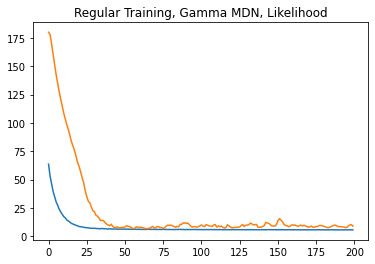

In [23]:
# define gamma model
MDN_model_ref_gamma = model_generator(n_para=3)
MDN_model_ref_gamma.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=gamma_loss)
#MDN_model_ref_gamma.summary()
history_gamma = MDN_model_ref_gamma.fit(train_x, train_y, epochs=200, validation_data=[test_x, test_y])
plot_history(history_gamma, 'Regular Training, Gamma MDN, Likelihood')

Epoch 1/80
16/16 [==============================] - 11s 81ms/step - loss: 199.0508 - val_loss: 204.0836
Epoch 2/80
16/16 [==============================] - 0s 26ms/step - loss: 199.0134 - val_loss: 204.0834
Epoch 3/80
16/16 [==============================] - 0s 26ms/step - loss: 198.8674 - val_loss: 204.0824
Epoch 4/80
16/16 [==============================] - 0s 26ms/step - loss: 198.8008 - val_loss: 204.0806
Epoch 5/80
16/16 [==============================] - 0s 28ms/step - loss: 198.7091 - val_loss: 204.0780
Epoch 6/80
16/16 [==============================] - 1s 46ms/step - loss: 198.3481 - val_loss: 204.0742
Epoch 7/80
16/16 [==============================] - 1s 68ms/step - loss: 197.6625 - val_loss: 204.0688
Epoch 8/80
16/16 [==============================] - 1s 42ms/step - loss: 196.7148 - val_loss: 204.0617
Epoch 9/80
16/16 [==============================] - 0s 28ms/step - loss: 194.7108 - val_loss: 204.0524
Epoch 10/80
16/16 [==============================] - 0s 28ms/step - loss

16/16 [==============================] - 0s 27ms/step - loss: 63.1434 - val_loss: 146.8180


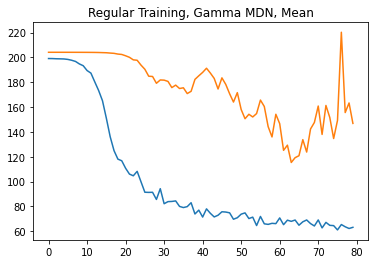

In [21]:
# define MDN Gamma Mean model
MDN_model_ref_gamma_mean = model_generator(n_para=3)
MDN_model_ref_gamma_mean.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=gamma_mean_loss)
history_gamma_mean = MDN_model_ref_gamma_mean.fit(train_x, train_y, epochs=80, validation_data=[test_x, test_y])
plot_history(history_gamma_mean, 'Regular Training, Gamma MDN, Mean')

Epoch 1/200
16/16 [==============================] - 12s 100ms/step - loss: 62.5850 - val_loss: 165.7774
Epoch 2/200
16/16 [==============================] - 1s 34ms/step - loss: 53.1651 - val_loss: 166.4678
Epoch 3/200
16/16 [==============================] - 1s 37ms/step - loss: 45.8832 - val_loss: 160.6608
Epoch 4/200
16/16 [==============================] - 1s 35ms/step - loss: 39.7374 - val_loss: 154.2601
Epoch 5/200
16/16 [==============================] - 1s 37ms/step - loss: 34.3650 - val_loss: 147.1115
Epoch 6/200
16/16 [==============================] - 1s 38ms/step - loss: 30.6276 - val_loss: 139.9658
Epoch 7/200
16/16 [==============================] - 1s 36ms/step - loss: 27.1943 - val_loss: 133.1129
Epoch 8/200
16/16 [==============================] - 1s 37ms/step - loss: 24.5809 - val_loss: 126.7268
Epoch 9/200
16/16 [==============================] - 1s 34ms/step - loss: 21.9697 - val_loss: 121.3874
Epoch 10/200
16/16 [==============================] - 1s 40ms/step - lo

16/16 [==============================] - 1s 35ms/step - loss: 6.4815 - val_loss: 7.4623
Epoch 82/200
16/16 [==============================] - 1s 34ms/step - loss: 6.4426 - val_loss: 6.8944
Epoch 83/200
16/16 [==============================] - 1s 36ms/step - loss: 6.4333 - val_loss: 6.7733
Epoch 84/200
16/16 [==============================] - 1s 35ms/step - loss: 6.4956 - val_loss: 6.6814
Epoch 85/200
16/16 [==============================] - 1s 35ms/step - loss: 6.4909 - val_loss: 6.8926
Epoch 86/200
16/16 [==============================] - 1s 39ms/step - loss: 6.4886 - val_loss: 7.4573
Epoch 87/200
16/16 [==============================] - 1s 39ms/step - loss: 6.4401 - val_loss: 7.2678
Epoch 88/200
16/16 [==============================] - 1s 40ms/step - loss: 6.4318 - val_loss: 7.3283
Epoch 89/200
16/16 [==============================] - 1s 38ms/step - loss: 6.4863 - val_loss: 7.0196
Epoch 90/200
16/16 [==============================] - 1s 39ms/step - loss: 6.4686 - val_loss: 6.8070
Epo

16/16 [==============================] - 1s 37ms/step - loss: 6.3449 - val_loss: 7.7996
Epoch 162/200
16/16 [==============================] - 1s 36ms/step - loss: 6.3529 - val_loss: 7.4890
Epoch 163/200
16/16 [==============================] - 1s 36ms/step - loss: 6.3679 - val_loss: 7.3364
Epoch 164/200
16/16 [==============================] - 1s 36ms/step - loss: 6.3836 - val_loss: 7.4411
Epoch 165/200
16/16 [==============================] - 1s 42ms/step - loss: 6.3841 - val_loss: 8.2016
Epoch 166/200
16/16 [==============================] - 1s 43ms/step - loss: 6.3912 - val_loss: 8.0978
Epoch 167/200
16/16 [==============================] - 1s 42ms/step - loss: 6.3787 - val_loss: 8.2480
Epoch 168/200
16/16 [==============================] - 1s 41ms/step - loss: 6.3383 - val_loss: 7.8294
Epoch 169/200
16/16 [==============================] - 1s 40ms/step - loss: 6.3614 - val_loss: 7.4916
Epoch 170/200
16/16 [==============================] - 1s 39ms/step - loss: 6.3533 - val_loss: 7

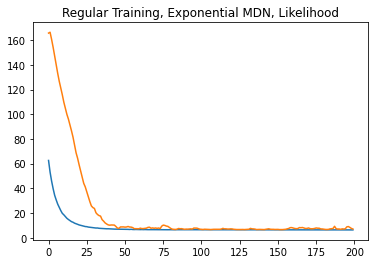

In [24]:
# define MDN Exponentialmodel
MDN_model_ref_exponential = model_generator(n_para=2)
MDN_model_ref_exponential.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=exponential_loss)
history_exponential = MDN_model_ref_exponential.fit(train_x, train_y, epochs=200, validation_data=[test_x, test_y])
plot_history(history_exponential, 'Regular Training, Exponential MDN, Likelihood')

The MAE between mean of MD and Y is not a stable loss to track.

## 3. Debug Meta Learning Algorithm

In [25]:
# define necessary tool functions
components = 100
no_parameters = 3
data = [g_data, m_data]
lats_lons = [G_lats, G_lons, M_lats, M_lons]
task_dim = 3
test_proportion = 0.5
n_lag = 10

# define MDN model
# input dim (time, channel, rows, cols)
input1 = layers.Input(shape=(n_lag, 1, task_dim, task_dim)) 
input1 = layers.BatchNormalization()(input1)
input2 = layers.Input(shape=(task_dim, task_dim, 1))
input2 = layers.BatchNormalization()(input2)
input3 = layers.Input(shape=(1))
input3 = layers.BatchNormalization()(input3)

X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='tanh', return_sequences=True)(input1)
X = layers.ConvLSTM2D(filters=20, kernel_size=(1,2), activation='relu', return_sequences=True)(X)
X = layers.ConvLSTM2D(filters=20, kernel_size=(1,1), activation='relu')(X)
X = layers.Flatten()(X)
X = layers.Dense(512, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dense(300, activation='relu')(X)

X1 = layers.Conv2D(20, (2,2), activation='tanh')(input2)
X1 = layers.Flatten()(X1)
X2 = layers.BatchNormalization()(input3)
X2 = layers.Dense(30, activation='relu')(X2)

X = layers.Concatenate()([X, X1, X2])
X = layers.Dense(128, activation='tanh')(X)
X = layers.BatchNormalization()(X)
X = layers.Dense(128, activation='relu')(X)
X = layers.BatchNormalization()(X)
X = layers.Dense(128, activation='tanh')(X)
X = layers.BatchNormalization()(X)
alphas = layers.Dense(components*task_dim*task_dim, activation="softmax")(X)
#alphas = layers.Reshape((task_dim, task_dim, components), name="alphas")(alphas)
mus = layers.Dense(components*task_dim*task_dim, activation='nnelu')(X)
#mus = layers.Reshape((task_dim, task_dim, components) ,name="mus")(mus)
sigmas = layers.Dense(components*task_dim*task_dim, activation="nnelu", name="sigmas")(X)
output = layers.Concatenate()([alphas, mus, sigmas])
MDN_model = Model([input1, input2, input3], output)

# define TaskExtractor

taskextractor = TaskExtractor(data, lats_lons, task_dim, test_proportion, n_lag)

In [26]:
reload(probdownscale.MetaTrain)
from probdownscale.MetaTrain import MetaSGD
# define meta learner
meta_optimizer = tf.keras.optimizers.Adam(0.0001)
inner_step = 1
inner_optimizer = tf.keras.optimizers.Adam(0.0001)

meta_learner = MetaSGD(MDN_model, gamma_loss,  meta_optimizer, inner_step, inner_optimizer, taskextractor)

In [ ]:
# meta train
meta_history = meta_learner.meta_fit(20, batch_size=10, basic_train=True, bootstrap_train=True, use_test_for_meta=True, randomize=True)
plt.plot(meta_history)
plt.title('Meta Training History')
plt.show()

Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  1 / 8 loss:  72.336075
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  2 / 8 loss:  69.37856
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  3 / 8 loss:  67.95126
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  4 / 8 loss:  62.241722
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  5 / 8 loss:  67.81808
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  6 / 8 loss:  62.390392
Meta lr: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=1e-04>
Epoch: 1 / 20  Basic training step:  7 / 8 loss:  62.08769
Meta lr: <tf.Variable 'learning_rate:0' shape

In [ ]:
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.0000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=5, validation_data=[test_x, test_y])

In [68]:
def inner_rate_function(inner_rate, batch_size, inner_step):
    return inner_rate/inner_step*math.log(batch_size, 20)

def meta_rate_function(meta_rate, batch_locations, seen_locations, covariance_function, distance_function):
    batch_size = len(batch_location)
    center = np.average(list(seen_locations.keys()), weights=list(seen_locations.values()), axis=0)
    batch_dist = np.mean([distance_function(locat, center) for locat in batch_locations])
    
inner_rate_f(0.01, 100, 5)

NameError: name 'inner_rate_f' is not defined

Text(0.5, 1.0, 'Meta Training History')

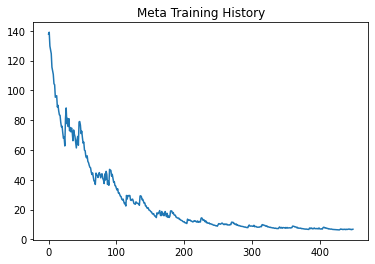

In [66]:
plt.plot(meta_history)
plt.title('Meta Training History')

In [69]:
trained_meta_model = meta_learner.meta_model
optimizer = tf.keras.optimizers.Adam(0.0000001)
trained_meta_model.compile(optimizer=optimizer, loss=gamma_loss)
trained_meta_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_148 (InputLayer)         [(None, 10, 1, 3, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_lstm2d_72 (ConvLSTM2D)    (None, 10, 1, 2, 20  3760        ['input_148[0][0]']              
                                )                                                                 
                                                                                                  
 conv_lstm2d_73 (ConvLSTM2D)    (None, 10, 1, 1, 20  6480        ['conv_lstm2d_72[1][0]']         
                                )                                                          

In [70]:
meta_history_fine_tune = trained_meta_model.fit(train_x, train_y, epochs=10, validation_data=[test_x, test_y])

Epoch 1/10
16/16 [==============================] - 11s 144ms/step - loss: 7.0205 - val_loss: 100.2038
Epoch 2/10
16/16 [==============================] - 1s 89ms/step - loss: 6.9077 - val_loss: 93.4999
Epoch 3/10
16/16 [==============================] - 1s 85ms/step - loss: 7.0396 - val_loss: 87.2813
Epoch 4/10
16/16 [==============================] - 1s 85ms/step - loss: 7.0445 - val_loss: 82.0647
Epoch 5/10
16/16 [==============================] - 1s 84ms/step - loss: 7.2663 - val_loss: 77.1205
Epoch 6/10
16/16 [==============================] - 1s 84ms/step - loss: 6.9881 - val_loss: 73.0638
Epoch 7/10
16/16 [==============================] - 1s 90ms/step - loss: 7.2018 - val_loss: 69.7954
Epoch 8/10
16/16 [==============================] - 1s 90ms/step - loss: 7.1933 - val_loss: 66.5253
Epoch 9/10
16/16 [==============================] - 1s 85ms/step - loss: 6.9173 - val_loss: 63.7211
Epoch 10/10
16/16 [==============================] - 1s 85ms/step - loss: 7.1585 - val_loss: 60.7